## VAE for Face Generating - Gen AI

### Name: Jayesh Mohanani
### Reg No.: 2448026

----

### Importing Dataset

----

In [ ]:
import zipfile

zip_path = "/content/celebA-HQ.zip"  # or your actual filename
output_dir = "/content/celebA-HQ"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

In [ ]:
!pip install tensorflow --quiet

### Importing Libraries

----

In [ ]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

### Creating proper dataset with images

---

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 128

image_dir = "/content/celebA-HQ/celeba_hq_256"

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img

all_image_paths = [
    os.path.join(image_dir, fname)
    for fname in os.listdir(image_dir)
    if fname.lower().endswith(".jpg")
]
all_image_paths = tf.constant(all_image_paths, dtype=tf.string)

print("Number of images:", len(all_image_paths))

dataset = tf.data.Dataset.from_tensor_slices(all_image_paths)
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=2048).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).repeat()

Number of images: 30000


### Making the Encoder and Decoder layers

----

In [ ]:
LATENT_DIM = 256  # Change to your preference/model

# Encoder
encoder_inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = Conv2D(32, 4, strides=2, activation='relu', padding='same')(encoder_inputs)
x = Conv2D(64, 4, strides=2, activation='relu', padding='same')(x)
x = Conv2D(128, 4, strides=2, activation='relu', padding='same')(x)
x = Conv2D(256, 4, strides=2, activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
z_mean = Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = Dense(LATENT_DIM, name="z_log_var")(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], LATENT_DIM))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(LATENT_DIM,), name='z')([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
latent_inputs = Input(shape=(LATENT_DIM,))
x = Dense(8*8*128, activation='relu')(latent_inputs)
x = Reshape((8, 8, 128))(x)
x = Conv2DTranspose(256, 4, strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(128, 4, strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(64, 4, strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(32, 4, strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(16, 4, strides=2, activation='relu', padding='same')(x)
decoder_outputs = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
decoder = Model(latent_inputs, decoder_outputs, name='decoder')

### Making the Model

----

In [ ]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")

    def compile(self, optimizer):
        super(VAE, self).compile()
        self.optimizer = optimizer

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.square(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            loss = reconstruction_loss + kl_loss
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(loss)
        return {"loss": self.total_loss_tracker.result()}

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

### Performing Epochs

----

In [ ]:
print("Number of images:", len(all_image_paths))
print("Batch size:", BATCH_SIZE)
STEPS_PER_EPOCH = max(1, len(all_image_paths) // BATCH_SIZE)
print("Steps per epoch:", STEPS_PER_EPOCH)

EPOCHS = 10
beta = 0.2

vae.fit(
    dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH
)

Number of images: 30000
Batch size: 128
Steps per epoch: 234
Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 115s 354ms/step - loss: 0.0757
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 97s 368ms/step - loss: 0.0590
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 87s 371ms/step - loss: 0.0577
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 86s 368ms/step - loss: 0.0572
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 86s 366ms/step - loss: 0.0568
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 85s 365ms/step - loss: 0.0568
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 85s 364ms/step - loss: 0.0566
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 85s 364ms/step - loss: 0.0566
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 85s 363ms/step - loss: 0.0566
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 85s 363ms/step - loss: 0.0562


### Output Generation

----

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


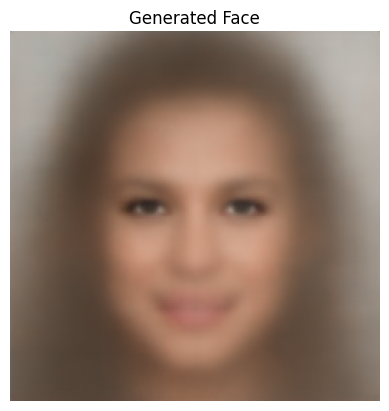

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a random latent vector
latent = np.random.randn(1, LATENT_DIM).astype(np.float32)

# Generate an image from the decoder
img = decoder.predict(latent)[0]
img = np.clip(img, 0, 1)

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')
plt.title('Generated Face')
plt.show()

### Saving the Model

----

In [ ]:
vae.save('/content/vae_model.h5')

In [ ]:
from google.colab import files

files.download('/content/vae_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>